In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time

In [3]:
import pickle
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from operator import itemgetter
THREADS = 16
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import time
import torch.nn.functional as F
loss_func = torch.nn.MSELoss()

In [4]:
ratings = pd.read_pickle('/content/gdrive/My Drive/drive/data/netflix/movie_ratings_500_id.pkl')
films = pd.read_pickle('/content/gdrive/My Drive/drive/data/netflix/movie_metadata.pkl')

In [5]:
row = []
for mid,haha in ratings.items():
    for info in haha:
        info['movie'] = mid
        row.append(info)
df_ratings = pd.DataFrame(row)
row = []
for mid,haha in films.items():
    haha['movie'] = mid
    row.append(haha)
df_movie = pd.DataFrame(row)

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
final = pd.merge(df_movie,df_ratings,on='movie')
a = final['user_id'].value_counts()[final['user_id'].value_counts() >= 10]
final = final[final['user_id'].isin(list(a.index))]
final.index = range(len(final))
hehe = final.copy()
del hehe['title']
del hehe['user_rating_date']

In [8]:
movie = dict()
for i in range(df_movie.shape[0]):
    m = df_movie['movie'][i]
    movie.setdefault(m,dict())
    movie[m]['director'] = df_movie['director'][i]
    movie[m]['genre'] = df_movie['genre'][i]
    movie[m]['actors'] = df_movie['actors'][i]
    movie[m]['title'] = df_movie['title'][i]

In [9]:
def map_aspect_values_to_movies(x):
    (film, meta), aspect = x
    aspects = dict()
    if aspect == "director":
        aspects[meta[aspect]] = 1
    else:
        for g in meta[aspect]:
            aspects[g] = 1
    return film, meta, aspects


def dict_movie_aspect(paper_films, aspect):
    paper_films_aspect_prepended = map(
        lambda e: (e, aspect), list(paper_films.items()))
    aspect_dict = dict()
    with ProcessPoolExecutor(max_workers=THREADS) as executor:
        results = executor.map(map_aspect_values_to_movies,
                               paper_films_aspect_prepended)
    for film, meta, aspects in results:
        aspect_dict[film + "_" + meta["title"]] = aspects
    return aspect_dict

In [10]:
movie_genres = dict_movie_aspect(movie, "genre")
movie_directors = dict_movie_aspect(movie,'director')
movie_actors = dict_movie_aspect(movie,'actors')
actors = pd.DataFrame.from_dict(movie_actors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
directors = pd.DataFrame.from_dict(movie_directors,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index
genres = pd.DataFrame.from_dict(movie_genres,dtype = 'int64',orient = 'index').T.replace(np.nan, 0).index

In [11]:
actors_dict = dict(zip(actors, range(len(actors))))
directors_dict = dict(zip(directors, range(
    len(actors), len(actors) + len(directors))))
genres_dict = dict(zip(genres, range(
    len(actors) + len(directors), len(actors) + len(directors) + len(genres))))
# max(actors_dict.values()),max(directors_dict.values()),max(genres_dict.values())

In [12]:
def change_director(x):
    return [itemgetter(x)(directors_dict)]


def change_actor(x):
    return change_list((itemgetter(*x)(actors_dict)))


def change_genre(x):
    qunima = itemgetter(*x)(genres_dict)
    if type(qunima) == int:
        return [qunima]
    else:
        return change_list(qunima)


def change_list(x):
    return list(x)

In [13]:
hehe['director'] = hehe['director'].map(change_director)
hehe['actors'] = hehe['actors'].map(change_actor)
hehe['genre'] = hehe['genre'].map(change_genre)

In [14]:
hehe = hehe[['user_id','movie','actors','director','genre','user_rating']]
hehe['user_rating'] = hehe['user_rating'].astype('float')

In [15]:
le = LabelEncoder()
y_user = le.fit_transform(hehe['user_id'])
hehe['user_id'] = y_user

y_item = le.fit_transform(hehe['movie'])
hehe['movie'] = y_item


In [16]:
print("The number of aspects is {}".format(max(genres_dict.values()) + 1))
print("The number of users is {}".format(max(hehe['user_id'])+1))

The number of aspects is 1154
The number of users is 5128


In [17]:
from tqdm import tqdm
from torch.nn import LeakyReLU
leaky = LeakyReLU(0.0)

def calculate_score(x, users, aspects):
    niubi = []
    # users: 128 * 8
    first = x.index[0]
    val_base = x[first]
    actor_base = torch.LongTensor(val_base).to(DEVICE)
    actors_base = aspects(actor_base)  # 3 * 8
    #actors_base = actors_base + items[first % 128].unsqueeze(1)
    #actors_base = F.dropout(actors_base, p=rate, training=True)
    pre_rating = torch.mm(actors_base, users[first].unsqueeze(1))
    niubi.append(pre_rating)
    pre_rating = pre_rating / pre_rating.shape[0]
    pre_rating = pre_rating.sum(0)
    for i in x.index[1:]:
        val = x[i]
        actor = torch.LongTensor(val).to(DEVICE)
        actors = aspects(actor)
        pre_ra = torch.mm(actors, users[i].unsqueeze(1))
        niubi.append(pre_ra)
        actors_f = pre_ra / pre_ra.shape[0]
        actors_f = actors_f.sum(0)
        pre_rating = torch.cat((pre_rating, actors_f))
    return pre_rating, niubi


class aspect_augumentation(nn.Module):
    def __init__(self, n_users, n_entity, n_rk, n_factors):
        super(aspect_augumentation, self).__init__()
        self.n_users = n_users
        self.n_entity = n_entity
        self.n_rk = n_rk
        self.n_factors = n_factors
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.entity_factors = torch.nn.Embedding(n_entity, n_factors)
        self.relation_k = torch.nn.Embedding(n_factors, n_rk)
        

    def forward(self, user_id, actors_id, directors_id, genres_id):
        '''
        user_factors: n_users * 64
        entity_factors: n_entity * 64
        relation_k: 64 * 3
        '''
        
        users = self.user_factors(user_id)  # 128 * 8
        aspects = self.entity_factors  # n_entity * 8
        users = F.dropout(users, p=rate, training=self.training)
        scores = torch.matmul(users, F.dropout(self.relation_k.weight, p=rate, training=self.training))  # 128 * 3
        scores = leaky(scores)
        m=torch.nn.Softmax(dim=1)  # 128 * 3
        scores=m(scores)  # 128 * 3

        '''
        Compute the importance of each aspects
        '''
        scores_actors=scores[:, 0] # 128,
        scores_directors=scores[:, 1] # 128,
        scores_genres=scores[:, 2] # 128,

        '''
        Compute the contribution of each aspects
        '''
        contribute_actors,niubi_act=calculate_score(
            actors_id, users,aspects)
        contribute_directors, niubi_dir=calculate_score(
            directors_id, users,aspects)
        contribute_genres, niubi_gen=calculate_score(
            genres_id, users, aspects)

        '''
        Compute the final predictions
        '''
        importance_sum=scores_actors + scores_directors + scores_genres
        prediction_sum=contribute_actors * scores_actors + contribute_directors * scores_directors + contribute_genres * scores_genres
        prediction=prediction_sum / importance_sum
        cnm = [niubi_act,niubi_dir,niubi_gen]

        return prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm

In [18]:
def RMSE(data, model,batch_size,items):
    users_index = data.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
#     items_index = data.iloc[:, 0].values
#     items = torch.LongTensor(items_index).to(DEVICE)
    actors_id = data.iloc[:, 2]
    directors_id = data.iloc[:, 3]
    genres_id = data.iloc[:, 4]
    rating = torch.FloatTensor(
        data.iloc[:, 5].values).to(DEVICE)
    rating = (rating + 1) * 2 + 1
    prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm = model(users,actors_id, directors_id, genres_id)
    prediction = (prediction + 1) * 2 + 1
    rmse = loss_func(prediction, rating)
    mae = torch.nn.L1Loss()(prediction, rating)

    return rmse ** 0.5,mae, cnm

In [19]:
def train(lr, dim, reg, batch_size, num_epochs, data, test):
    model = aspect_augumentation(5128, 1154, 3, dim).to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, threshold=0.005, threshold_mode='abs')
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()
        num_example = len(data)
        indices = list(range(num_example))
        for i in tqdm(range(0, num_example, batch_size)):
            
            indexs = indices[i:min(i+batch_size, num_example)]
            users_index = data.iloc[:, 0].loc[indexs].values
            users = torch.LongTensor(users_index).to(DEVICE)
            items_index = data.iloc[:, 0].values
            items = torch.LongTensor(items_index).to(DEVICE)
            actors_id = data.iloc[:, 2].loc[indexs]
            actors_id.index = range(len(actors_id))
            directors_id = data.iloc[:, 3].loc[indexs]
            directors_id.index = range(len(directors_id))
            genres_id = data.iloc[:, 4].loc[indexs]
            genres_id.index = range(len(genres_id))
            rating = torch.FloatTensor(
                data.iloc[:, 5].loc[indexs].values).to(DEVICE)
            prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = model(
                users, actors_id, directors_id, genres_id)
            #prediction = (prediction + 1) * 2 + 1
            optimizer.zero_grad()
            err = loss_func(prediction, rating) + reg * ((model.user_factors.weight*model.user_factors.weight).sum() +
                                                         (model.entity_factors.weight*model.entity_factors.weight).sum() +
                                                         (model.relation_k.weight*model.relation_k.weight).sum())

            err.backward()
            optimizer.step()
        t2 = time.time()
        rmse, mae, cnm = RMSE(test, model,batch_size,items)
        scheduler.step(rmse)
        print("Epoch: ", epoch, " Loss: ", err, " RMSE in test set:",
              rmse, "MAE in test set: ", mae)
        print("Time consumed is:", t2-t1)
    return rmse, mae, model, cnm

In [20]:
hehe['user_rating'] = (hehe['user_rating'] - 1) / 2 - 1

In [21]:

trainset = hehe.sample(frac=0.8, random_state=0, axis=0)
trainset.index = range(len(trainset))
testset = hehe[~hehe.index.isin(trainset.index)]
testset.index = range(len(testset))
rate = 0.0

In [22]:
def grid(lrs, dims, regs, batch_sizes, num_epochs, data, test):
    res = []
    models = []
    qnm = []
    for lr in lrs:
        for dim in dims:
            for reg in regs:
                for batch_size in batch_sizes:
                    rmse, mae, model,cnm = train(
                        lr, dim, reg, batch_size, num_epochs, data, test)
                    res.append(rmse)
                    res.append(mae)
                    models.append(model)
                    qnm.append(cnm)
    return res, models,qnm

In [23]:
lrs = [1e-2]
dims = [8]
regs = [5e-7]
batch_sizes = [512]
num_epochs = 100
rmse, mae, model, cnm = train(lrs[0],dims[0],regs[0],batch_sizes[0],num_epochs,trainset,testset)

100%|██████████| 302/302 [01:32<00:00,  3.25it/s]


Epoch:  0  Loss:  tensor(0.4309, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.2652, grad_fn=<PowBackward0>) MAE in test set:  tensor(1.0037, grad_fn=<L1LossBackward0>)
Time consumed is: 93.01307988166809


100%|██████████| 302/302 [01:36<00:00,  3.11it/s]


Epoch:  1  Loss:  tensor(0.3070, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0793, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.8614, grad_fn=<L1LossBackward0>)
Time consumed is: 97.01012086868286


100%|██████████| 302/302 [01:35<00:00,  3.16it/s]


Epoch:  2  Loss:  tensor(0.2691, grad_fn=<AddBackward0>)  RMSE in test set: tensor(1.0055, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7996, grad_fn=<L1LossBackward0>)
Time consumed is: 95.65051031112671


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


Epoch:  3  Loss:  tensor(0.2474, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9646, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7642, grad_fn=<L1LossBackward0>)
Time consumed is: 97.71531462669373


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  4  Loss:  tensor(0.2354, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9389, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7415, grad_fn=<L1LossBackward0>)
Time consumed is: 100.28119277954102


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


Epoch:  5  Loss:  tensor(0.2266, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9205, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7255, grad_fn=<L1LossBackward0>)
Time consumed is: 96.8994209766388


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  6  Loss:  tensor(0.2184, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.9052, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7120, grad_fn=<L1LossBackward0>)
Time consumed is: 98.344566822052


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


Epoch:  7  Loss:  tensor(0.2110, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8918, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.7001, grad_fn=<L1LossBackward0>)
Time consumed is: 97.7338879108429


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  8  Loss:  tensor(0.2010, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8798, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6892, grad_fn=<L1LossBackward0>)
Time consumed is: 99.03611755371094


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


Epoch:  9  Loss:  tensor(0.1931, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6796, grad_fn=<L1LossBackward0>)
Time consumed is: 96.95470833778381


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  10  Loss:  tensor(0.1877, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8606, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6710, grad_fn=<L1LossBackward0>)
Time consumed is: 99.78519487380981


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  11  Loss:  tensor(0.1788, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8525, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6633, grad_fn=<L1LossBackward0>)
Time consumed is: 100.2308578491211


100%|██████████| 302/302 [01:40<00:00,  3.00it/s]


Epoch:  12  Loss:  tensor(0.1721, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8455, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6566, grad_fn=<L1LossBackward0>)
Time consumed is: 100.53334975242615


100%|██████████| 302/302 [01:41<00:00,  2.98it/s]


Epoch:  13  Loss:  tensor(0.1648, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8392, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6504, grad_fn=<L1LossBackward0>)
Time consumed is: 101.4190742969513


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  14  Loss:  tensor(0.1600, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8336, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6447, grad_fn=<L1LossBackward0>)
Time consumed is: 99.79467940330505


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  15  Loss:  tensor(0.1566, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8284, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6396, grad_fn=<L1LossBackward0>)
Time consumed is: 100.36964750289917


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  16  Loss:  tensor(0.1514, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8237, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6350, grad_fn=<L1LossBackward0>)
Time consumed is: 100.3152527809143


100%|██████████| 302/302 [01:39<00:00,  3.04it/s]


Epoch:  17  Loss:  tensor(0.1479, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8194, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6309, grad_fn=<L1LossBackward0>)
Time consumed is: 99.37623047828674


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  18  Loss:  tensor(0.1454, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8154, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6271, grad_fn=<L1LossBackward0>)
Time consumed is: 98.35535430908203


100%|██████████| 302/302 [01:37<00:00,  3.08it/s]


Epoch:  19  Loss:  tensor(0.1439, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8120, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6238, grad_fn=<L1LossBackward0>)
Time consumed is: 97.94350242614746


100%|██████████| 302/302 [01:38<00:00,  3.05it/s]


Epoch:  20  Loss:  tensor(0.1408, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8084, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6207, grad_fn=<L1LossBackward0>)
Time consumed is: 98.90346765518188


100%|██████████| 302/302 [01:44<00:00,  2.88it/s]


Epoch:  21  Loss:  tensor(0.1396, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8056, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6179, grad_fn=<L1LossBackward0>)
Time consumed is: 104.87434554100037


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  22  Loss:  tensor(0.1374, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8029, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6152, grad_fn=<L1LossBackward0>)
Time consumed is: 99.78041386604309


100%|██████████| 302/302 [01:38<00:00,  3.05it/s]


Epoch:  23  Loss:  tensor(0.1356, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.8007, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6128, grad_fn=<L1LossBackward0>)
Time consumed is: 98.95236897468567


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  24  Loss:  tensor(0.1342, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7984, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6105, grad_fn=<L1LossBackward0>)
Time consumed is: 99.80102109909058


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  25  Loss:  tensor(0.1332, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7968, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6088, grad_fn=<L1LossBackward0>)
Time consumed is: 100.3443512916565


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  26  Loss:  tensor(0.1318, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7950, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6070, grad_fn=<L1LossBackward0>)
Time consumed is: 99.57459926605225


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  27  Loss:  tensor(0.1314, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7938, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6056, grad_fn=<L1LossBackward0>)
Time consumed is: 100.49044585227966


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  28  Loss:  tensor(0.1306, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7924, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6043, grad_fn=<L1LossBackward0>)
Time consumed is: 99.57606935501099


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  29  Loss:  tensor(0.1296, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7913, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6030, grad_fn=<L1LossBackward0>)
Time consumed is: 100.18286681175232


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  30  Loss:  tensor(0.1298, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7907, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6019, grad_fn=<L1LossBackward0>)
Time consumed is: 98.70299792289734


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  31  Loss:  tensor(0.1287, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7895, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.6006, grad_fn=<L1LossBackward0>)
Time consumed is: 100.11902165412903


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  32  Loss:  tensor(0.1286, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7885, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5995, grad_fn=<L1LossBackward0>)
Time consumed is: 100.12824201583862


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


Epoch:  33  Loss:  tensor(0.1283, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7873, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5982, grad_fn=<L1LossBackward0>)
Time consumed is: 96.90084505081177


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  34  Loss:  tensor(0.1282, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7864, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5973, grad_fn=<L1LossBackward0>)
Time consumed is: 99.11878108978271


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  35  Loss:  tensor(0.1278, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7856, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5962, grad_fn=<L1LossBackward0>)
Time consumed is: 99.10190200805664


100%|██████████| 302/302 [01:47<00:00,  2.80it/s]


Epoch:  36  Loss:  tensor(0.1277, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7849, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5954, grad_fn=<L1LossBackward0>)
Time consumed is: 107.85960674285889


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  37  Loss:  tensor(0.1274, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7839, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5943, grad_fn=<L1LossBackward0>)
Time consumed is: 100.19218826293945


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  38  Loss:  tensor(0.1268, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7835, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5938, grad_fn=<L1LossBackward0>)
Time consumed is: 100.17797613143921


100%|██████████| 302/302 [01:40<00:00,  3.00it/s]


Epoch:  39  Loss:  tensor(0.1264, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7831, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5931, grad_fn=<L1LossBackward0>)
Time consumed is: 100.84711146354675


100%|██████████| 302/302 [01:40<00:00,  3.00it/s]


Epoch:  40  Loss:  tensor(0.1171, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7766, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5852, grad_fn=<L1LossBackward0>)
Time consumed is: 100.70455193519592


100%|██████████| 302/302 [01:42<00:00,  2.95it/s]


Epoch:  41  Loss:  tensor(0.1154, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7750, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5835, grad_fn=<L1LossBackward0>)
Time consumed is: 102.39303994178772


100%|██████████| 302/302 [01:41<00:00,  2.98it/s]


Epoch:  42  Loss:  tensor(0.1146, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7742, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5826, grad_fn=<L1LossBackward0>)
Time consumed is: 101.29661560058594


100%|██████████| 302/302 [01:42<00:00,  2.95it/s]


Epoch:  43  Loss:  tensor(0.1140, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7735, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5820, grad_fn=<L1LossBackward0>)
Time consumed is: 102.34207487106323


100%|██████████| 302/302 [01:39<00:00,  3.04it/s]


Epoch:  44  Loss:  tensor(0.1136, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7731, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5814, grad_fn=<L1LossBackward0>)
Time consumed is: 99.44388365745544


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  45  Loss:  tensor(0.1136, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7728, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5809, grad_fn=<L1LossBackward0>)
Time consumed is: 100.02516150474548


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  46  Loss:  tensor(0.1128, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7724, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5805, grad_fn=<L1LossBackward0>)
Time consumed is: 99.66987609863281


100%|██████████| 302/302 [01:42<00:00,  2.96it/s]


Epoch:  47  Loss:  tensor(0.1099, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7709, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5782, grad_fn=<L1LossBackward0>)
Time consumed is: 102.11282587051392


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  48  Loss:  tensor(0.1088, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7702, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5775, grad_fn=<L1LossBackward0>)
Time consumed is: 98.33930277824402


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  49  Loss:  tensor(0.1080, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7697, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5770, grad_fn=<L1LossBackward0>)
Time consumed is: 99.81387519836426


100%|██████████| 302/302 [01:40<00:00,  3.00it/s]


Epoch:  50  Loss:  tensor(0.1076, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7694, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5766, grad_fn=<L1LossBackward0>)
Time consumed is: 100.84882497787476


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  51  Loss:  tensor(0.1072, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7691, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5763, grad_fn=<L1LossBackward0>)
Time consumed is: 98.762216091156


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


Epoch:  52  Loss:  tensor(0.1068, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7688, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5761, grad_fn=<L1LossBackward0>)
Time consumed is: 96.91433453559875


100%|██████████| 302/302 [01:55<00:00,  2.61it/s]


Epoch:  53  Loss:  tensor(0.1065, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7685, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5757, grad_fn=<L1LossBackward0>)
Time consumed is: 115.8699209690094


100%|██████████| 302/302 [01:43<00:00,  2.92it/s]


Epoch:  54  Loss:  tensor(0.1055, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7677, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5749, grad_fn=<L1LossBackward0>)
Time consumed is: 103.46740412712097


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  55  Loss:  tensor(0.1048, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7674, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5746, grad_fn=<L1LossBackward0>)
Time consumed is: 100.12786674499512


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  56  Loss:  tensor(0.1044, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7672, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5743, grad_fn=<L1LossBackward0>)
Time consumed is: 98.32678699493408


100%|██████████| 302/302 [01:40<00:00,  3.00it/s]


Epoch:  57  Loss:  tensor(0.1040, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7670, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5742, grad_fn=<L1LossBackward0>)
Time consumed is: 100.57178163528442


100%|██████████| 302/302 [01:41<00:00,  2.96it/s]


Epoch:  58  Loss:  tensor(0.1038, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7669, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5740, grad_fn=<L1LossBackward0>)
Time consumed is: 101.9014539718628


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  59  Loss:  tensor(0.1035, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7667, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5738, grad_fn=<L1LossBackward0>)
Time consumed is: 99.17880272865295


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  60  Loss:  tensor(0.1031, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7662, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5734, grad_fn=<L1LossBackward0>)
Time consumed is: 98.28386974334717


100%|██████████| 302/302 [01:42<00:00,  2.95it/s]


Epoch:  61  Loss:  tensor(0.1029, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7660, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5733, grad_fn=<L1LossBackward0>)
Time consumed is: 102.24553513526917


100%|██████████| 302/302 [01:40<00:00,  2.99it/s]


Epoch:  62  Loss:  tensor(0.1026, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7660, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5732, grad_fn=<L1LossBackward0>)
Time consumed is: 100.86773419380188


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  63  Loss:  tensor(0.1024, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5731, grad_fn=<L1LossBackward0>)
Time consumed is: 98.275066614151


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  64  Loss:  tensor(0.1022, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7659, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5730, grad_fn=<L1LossBackward0>)
Time consumed is: 98.80889678001404


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  65  Loss:  tensor(0.1021, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5729, grad_fn=<L1LossBackward0>)
Time consumed is: 99.60769867897034


100%|██████████| 302/302 [01:40<00:00,  3.01it/s]


Epoch:  66  Loss:  tensor(0.1019, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5729, grad_fn=<L1LossBackward0>)
Time consumed is: 100.26186728477478


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  67  Loss:  tensor(0.1018, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7658, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5728, grad_fn=<L1LossBackward0>)
Time consumed is: 98.4596540927887


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  68  Loss:  tensor(0.1017, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7657, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5728, grad_fn=<L1LossBackward0>)
Time consumed is: 98.72101473808289


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  69  Loss:  tensor(0.1016, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7657, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5727, grad_fn=<L1LossBackward0>)
Time consumed is: 98.54817938804626


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  70  Loss:  tensor(0.1014, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7655, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5725, grad_fn=<L1LossBackward0>)
Time consumed is: 98.42822098731995


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  71  Loss:  tensor(0.1013, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7654, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5725, grad_fn=<L1LossBackward0>)
Time consumed is: 100.04018521308899


100%|██████████| 302/302 [01:41<00:00,  2.97it/s]


Epoch:  72  Loss:  tensor(0.1012, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7654, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5724, grad_fn=<L1LossBackward0>)
Time consumed is: 101.84288334846497


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  73  Loss:  tensor(0.1011, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7654, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5724, grad_fn=<L1LossBackward0>)
Time consumed is: 99.08991932868958


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


Epoch:  74  Loss:  tensor(0.1010, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7654, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5724, grad_fn=<L1LossBackward0>)
Time consumed is: 97.59444046020508


100%|██████████| 302/302 [01:39<00:00,  3.02it/s]


Epoch:  75  Loss:  tensor(0.1009, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7654, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5723, grad_fn=<L1LossBackward0>)
Time consumed is: 99.99058413505554


100%|██████████| 302/302 [01:42<00:00,  2.96it/s]


Epoch:  76  Loss:  tensor(0.1008, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5723, grad_fn=<L1LossBackward0>)
Time consumed is: 102.19602751731873


100%|██████████| 302/302 [01:40<00:00,  3.02it/s]


Epoch:  77  Loss:  tensor(0.1008, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 100.17105770111084


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  78  Loss:  tensor(0.1007, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 99.65358209609985


100%|██████████| 302/302 [01:37<00:00,  3.11it/s]


Epoch:  79  Loss:  tensor(0.1007, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7653, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 97.06085300445557


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  80  Loss:  tensor(0.1006, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 99.74656987190247


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  81  Loss:  tensor(0.1006, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 98.77566027641296


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


Epoch:  82  Loss:  tensor(0.1005, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 97.58103156089783


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  83  Loss:  tensor(0.1005, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5722, grad_fn=<L1LossBackward0>)
Time consumed is: 98.70212173461914


100%|██████████| 302/302 [01:37<00:00,  3.09it/s]


Epoch:  84  Loss:  tensor(0.1005, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 97.8475661277771


100%|██████████| 302/302 [01:39<00:00,  3.04it/s]


Epoch:  85  Loss:  tensor(0.1005, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.43649244308472


100%|██████████| 302/302 [01:39<00:00,  3.05it/s]


Epoch:  86  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.11326336860657


100%|██████████| 302/302 [01:38<00:00,  3.07it/s]


Epoch:  87  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.45294666290283


100%|██████████| 302/302 [01:38<00:00,  3.05it/s]


Epoch:  88  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.88527274131775


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  89  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.85428428649902


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  90  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.73614716529846


100%|██████████| 302/302 [01:38<00:00,  3.06it/s]


Epoch:  91  Loss:  tensor(0.1004, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.7129111289978


100%|██████████| 302/302 [01:40<00:00,  2.99it/s]


Epoch:  92  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 100.88289475440979


100%|██████████| 302/302 [01:38<00:00,  3.08it/s]


Epoch:  93  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 98.21327352523804


100%|██████████| 302/302 [01:39<00:00,  3.04it/s]


Epoch:  94  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.2907645702362


100%|██████████| 302/302 [01:39<00:00,  3.04it/s]


Epoch:  95  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.42118096351624


100%|██████████| 302/302 [01:37<00:00,  3.10it/s]


Epoch:  96  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 97.3632755279541


100%|██████████| 302/302 [01:36<00:00,  3.12it/s]


Epoch:  97  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 96.92659378051758


100%|██████████| 302/302 [01:39<00:00,  3.02it/s]


Epoch:  98  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.9218978881836


100%|██████████| 302/302 [01:39<00:00,  3.03it/s]


Epoch:  99  Loss:  tensor(0.1003, grad_fn=<AddBackward0>)  RMSE in test set: tensor(0.7652, grad_fn=<PowBackward0>) MAE in test set:  tensor(0.5721, grad_fn=<L1LossBackward0>)
Time consumed is: 99.61150002479553


In [24]:
state = { 'model': model.state_dict()}   
torch.save(state, '/content/gdrive/My Drive/drive/data/netflix/model_netflix_09059.pkl')
# hehe_model = aspect_augumentation(5128, 1154, 3, 8)
# checkpoint = torch.load('model_netflix.pkl')
# hehe_model.load_state_dict(checkpoint['model'])

In [25]:
!pip install umap-learn
!pip install "umap-learn[plot]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7cb8a274270d32c6cc9ebef9f776a139aca919aca52bd2c28f95e4904325afde
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=03548d57d8186741dbe096c4d92ac8a72a73439d7ff1298f9a339757f4139d61
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 801 kB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 


In [26]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
from umap import UMAP
import umap.plot

In [27]:
import networkx as nx
import matplotlib.pyplot as plt


def xiba(hehe,model):
    users_index = hehe.iloc[:, 0].values
    users = torch.LongTensor(users_index).to(DEVICE)
    actors_id = hehe.iloc[:, 2]
    directors_id = hehe.iloc[:, 3]
    genres_id = hehe.iloc[:, 4]
    rating = torch.FloatTensor(
        hehe.iloc[:, 5].values).to(DEVICE)
    prediction,scores,contribute_actors,contribute_directors,contribute_genres, cnm = model(users, actors_id, directors_id, genres_id)
    return prediction,scores,contribute_actors,contribute_directors,contribute_genres,cnm

In [28]:
prediction, scores, contribute_actors, contribute_directors, contribute_genres,cnm = xiba(testset,model)

In [29]:
rating = torch.FloatTensor(
        testset.iloc[:, 5].values)
rating

tensor([1.0000, 0.0000, 0.5000,  ..., 0.5000, 1.0000, 0.5000])

In [30]:
prediction

tensor([ 0.6775, -0.3084,  0.2390,  ...,  0.5217,  0.9111,  0.5586],
       grad_fn=<DivBackward0>)

In [31]:
X = scores.cpu().data.numpy()
from sklearn.cluster import KMeans

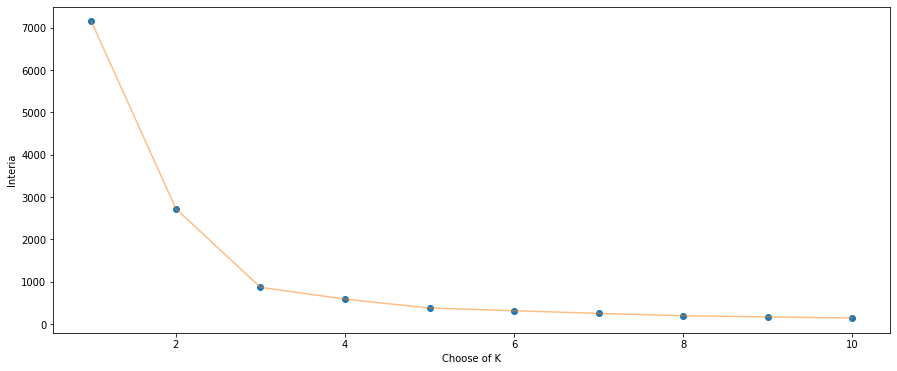

In [32]:
inertia = []   

for k in range(1,11):  
    algorithm = (KMeans(n_clusters=k,  
                       init="k-means++",  
                       n_init=10,  
                       max_iter=300,  
                       tol=0.0001,  
                       random_state=111,  
                       algorithm="full"))  
    algorithm.fit(X)  
    inertia.append(algorithm.inertia_) 
plt.figure(1,figsize=(15,6))
plt.plot(np.arange(1,11), inertia, 'o')  
plt.plot(np.arange(1,11), inertia, '-', alpha=0.5)

plt.xlabel("Choose of K")
plt.ylabel("Interia")
plt.show()

In [33]:
estimators = KMeans(n_clusters=3)
estimators.fit(X)
labele = estimators.labels_
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
data, label, n_samples, n_features,title = X, labele, 11604, 3,'Cluster of users according to importances of contexts'
print('Starting compute t-SNE Embedding...')
ts = TSNE(n_components=2, init='pca', random_state=0)

reslut = ts.fit_transform(data)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)

Starting compute t-SNE Embedding...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


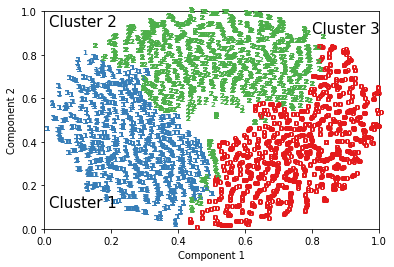

In [34]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(reslut.shape[0]):
    plt.text(reslut[i, 0], reslut[i, 1], str(label[i]), color=plt.cm.Set1(label[i]),
                 fontdict={'weight': 'bold', 'size': 7})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.text(0.015,0.93, 'Cluster 2', fontsize=15)
plt.text(0.015,0.10, 'Cluster 1', fontsize=15)
plt.text(0.80,0.9, 'Cluster 3', fontsize=15)
plt.xticks()
plt.yticks()
#plt.title(title, fontsize=14)
plt.savefig('/content/gdrive/My Drive/drive/data/netflix/jb_0909.png')
plt.show()

In [35]:
df_empty = pd.DataFrame(columns=['first','second','third','label'])
df_empty['first'] = X[:,0]
df_empty['second'] = X[:,1]
df_empty['third'] = X[:,2]
df_empty['label'] = labele

In [36]:
df_empty[df_empty['label'] == 0]['first'].mean(),df_empty[df_empty['label'] == 0]['second'].mean(),df_empty[df_empty['label'] == 0]['third'].mean()

(0.10714333, 0.1235355, 0.7693212)

In [37]:
df_empty[df_empty['label'] == 1]['first'].mean(),df_empty[df_empty['label'] == 1]['second'].mean(),df_empty[df_empty['label'] == 1]['third'].mean()

(0.850255, 0.08435004, 0.06539487)

In [38]:
df_empty[df_empty['label'] == 2]['first'].mean(),df_empty[df_empty['label'] == 2]['second'].mean(),df_empty[df_empty['label'] == 2]['third'].mean()

(0.33712015, 0.33332503, 0.32955483)

/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


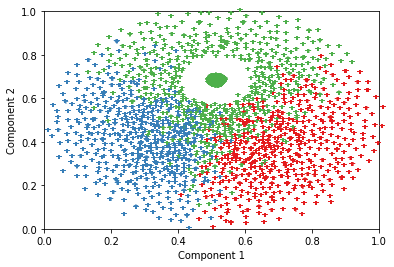

In [39]:
mapper = UMAP().fit(X)
reslut = UMAP().fit_transform(X)

x_min, x_max = np.min(reslut, 0), np.max(reslut, 0)
reslut = (reslut - x_min) / (x_max - x_min)

fig = plt.figure()
ax = plt.subplot(111)
for i in range(reslut.shape[0]):
    plt.text(reslut[i, 0], reslut[i, 1], '+', color=plt.cm.Set1(labele[i]),
                 fontdict={'weight': 'bold', 'size': 7})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xticks()
plt.yticks()
#plt.title(title, fize=14)
plt.savefig('/content/gdrive/My Drive/drive/data/netflix/jb_umap_0909.png')
plt.show()

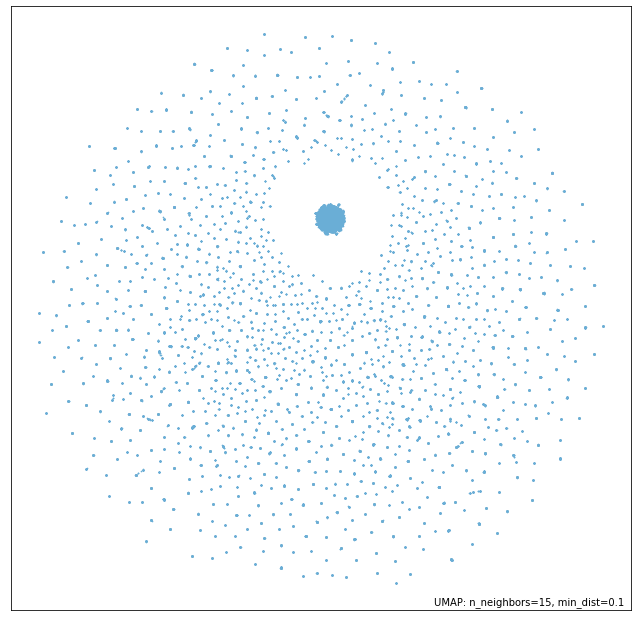

In [40]:
umap.plot.points(mapper)

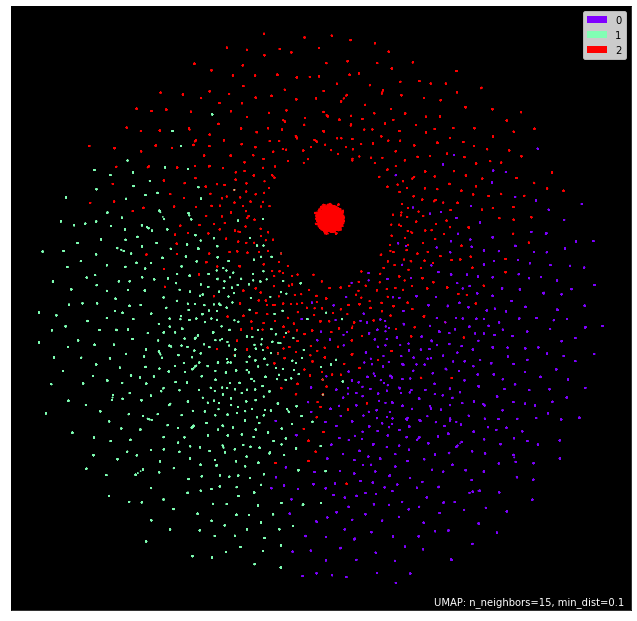

In [41]:
umap.plot.points(mapper, labels=labele, color_key_cmap='Paired', theme='fire')


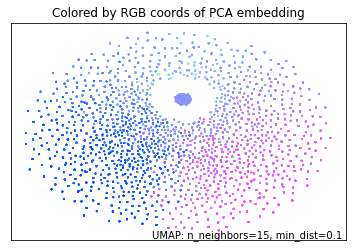

In [42]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

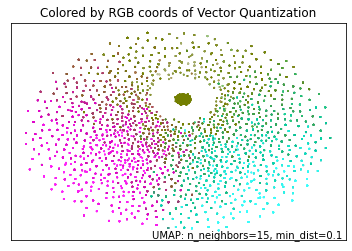

In [43]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')


In [44]:
testset

,user_id,movie,actors,director,genre,user_rating
0,2826,468,"[466, 114, 121]",[1074],"[1142, 1140, 1135]",1.0
1,1684,468,"[466, 114, 121]",[1074],"[1142, 1140, 1135]",0.0
2,5033,468,"[466, 114, 121]",[1074],"[1142, 1140, 1135]",0.5
3,318,468,"[466, 114, 121]",[1074],"[1142, 1140, 1135]",0.0
4,4322,468,"[466, 114, 121]",[1074],"[1142, 1140, 1135]",0.0
...,...,...,...,...,...,...
38611,120,488,"[405, 198, 744]",[1076],"[1135, 1137]",-0.5
38612,2147,488,"[405, 198, 744]",[1076],"[1135, 1137]",0.5
38613,1019,488,"[405, 198, 744]",[1076],"[1135, 1137]",0.5
38614,208,488,"[405, 198, 744]",[1076],"[1135, 1137]",1.0


In [63]:
i = 38613 ## the index of user-item interaction in the testset
item_map = dict(zip(y_item,final['title'].values))

user_index = testset['user_id'][i] ## user
item_index = testset['movie'][i]

movie_name = item_map[item_index]


dict_actors = {v:k for k,v in actors_dict.items()}
dict_directors = {v:k for k,v in directors_dict.items()}
dict_genres = {v:k for k,v in genres_dict.items()}


importance = scores.cpu().detach().numpy()
arg_actors = cnm[0][i].detach().numpy()
arg_directors = cnm[1][i].detach().numpy()
arg_genres = cnm[2][i].detach().numpy()

info = testset.iloc[i]
movies = info['movie']
actors_id = info['actors']
directors_id = info['director']
genres_id = info['genre']

actors_name = itemgetter(*actors_id)(dict_actors)
directors_name = itemgetter(*directors_id)(dict_directors)

genres_name = itemgetter(*genres_id)(dict_genres)

{('Christian Bale', 'The Machinist'): Text(1.5, 2.0, '0.09'),
 ('Jennifer Jason Leigh', 'The Machinist'): Text(1.5, 4.0, '0.0'),
 ('Aitana Sánchez-Gijón', 'The Machinist'): Text(4.0, 6.0, '0.49'),
 ('Brad Anderson', 'The Machinist'): Text(6.0, 4.0, '0.03'),
 ('Drama', 'The Machinist'): Text(6.0, 2.0, '-0.0'),
 ('Thriller', 'The Machinist'): Text(4.0, 2.0, '-0.01')}

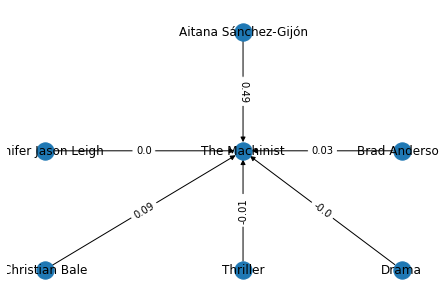

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

G=nx.DiGraph()

G.add_node(actors_name[0],pos=(-1,0))
G.add_node(actors_name[1],pos=(-1,4))
G.add_node(actors_name[2],pos=(4,8))
G.add_node(directors_name,pos=(8,4))
G.add_node(genres_name[0],pos=(8,0))
G.add_node(genres_name[1],pos=(4,0))
G.add_node(movie_name,pos=(4,4))


G.add_edge(actors_name[0],movie_name,weight=round(float(importance[i][0] * (max(arg_actors[0],0))/ 3),2))
G.add_edge(actors_name[1],movie_name,weight=round(float(importance[i][0] *(max(arg_actors[1],0)) / 3),2))
G.add_edge(actors_name[2],movie_name,weight=round(float(importance[i][0] *(max(arg_actors[2],0)) / 3),2))
G.add_edge(directors_name,movie_name,weight=round(float(importance[i][1] *(max(arg_directors[0],0)) / 1),2))
G.add_edge(genres_name[0],movie_name,weight=round(float(importance[i][2] *(float(arg_genres[0])) / 2),2))
G.add_edge(genres_name[1],movie_name,weight=round(float(importance[i][2] *(float(arg_genres[1])) / 2),2))


pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos,with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)